<a href="https://colab.research.google.com/github/srujayreddyv/CSC219-P2-TimeSeriesForecastingusingLSTMandCNN/blob/main/CSC219TeamProject_2_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CSC 219- Machine Learning (Fall 2023)


# Project 2: Time Series Forecasting using LSTM and CNN for Classification
### Team Challengers:
### 1. Alekya Paladugu
### 2. Samah Eltayeb
### 3. Srujay Reddy

# 1. 0 DOWNLOADING THE DATASET

In [ ]:
!pip install -U aeon[all_extras]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 58.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 10.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.9 

# 2.0 IMPORTS

In [ ]:
import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import zscore

import sklearn as sk
import tensorflow as tf
%load_ext tensorboard

import io
import os
import sys
import requests
import datetime
import shutil
from collections.abc import Sequence

%matplotlib inline
import matplotlib as pltLib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.feature_extraction.text as sk_text
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import optimizers

In [ ]:
# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for NumPy
np.random.seed(42)

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression

        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

def to_sequences(seq_size, data, labels):
    x = []
    y = []

    for i in range(len(data)-seq_size-1):
        #print(i)
        window = data[i:(i+seq_size)]
        after_window = labels[i+seq_size - 1]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)

    return np.array(x),np.array(y)

# 3.0 DATA PREPROCESSING

In [ ]:
from aeon.datasets import load_classification
#Classifies the fruits into strawberry and non-strawberry
X, y, meta_data = load_classification("Strawberry")
print(" Shape of X = ", X.shape)
print(" Shape of Y = ", y.shape)
print(" Meta data = ", meta_data)

 Shape of X =  (983, 1, 235)
 Shape of Y =  (983,)
 Meta data =  {'problemname': 'strawberry', 'timestamps': False, 'missing': False, 'univariate': True, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['1', '2']}


In [ ]:
X_train, y_train = load_classification(
    "Strawberry", extract_path="./Temp/", split="TRAIN", return_metadata=False
)
X_test, y_test = load_classification(
    "Strawberry", extract_path="./Temp/", split="test", return_metadata=False
)
print("Train shape = ", X_train.shape)
print("Test shape = ", X_test.shape)
from aeon.datasets import load_from_tsfile

X_train, y_train = load_from_tsfile(
    full_file_path_and_name="./Temp/Strawberry/Strawberry_TRAIN"
)
print("Loaded directly shape = ", X_train.shape)

Train shape =  (613, 1, 235)
Test shape =  (370, 1, 235)
Loaded directly shape =  (613, 1, 235)


In [ ]:
num_classes = 2
xl_train = np.array(X_train, dtype=np.float32)
xl_test = np.array(X_test, dtype=np.float32)

yl_train = np.array(y_train, dtype=np.int32)
yl_test = np.array(y_test, dtype=np.int32)

y_shift_train = yl_train - 1
y_shift_test = yl_test - 1

# Create an instance of the OneHotEncoder
y_2_train = tf.keras.utils.to_categorical(y_shift_train, num_classes)
y_2_test = tf.keras.utils.to_categorical(y_shift_test, num_classes)

num_samples, sequence_length, num_features = xl_train.shape

In [ ]:
sequence_length = 5
nums_classes = 2

xseq_train,yseq_train = to_sequences(sequence_length, xl_train, y_shift_train)
xseq_train = np.reshape(xseq_train, (xseq_train.shape[0], sequence_length, xseq_train.shape[-1]))

print(xseq_train.shape)

xseq_test,yseq_test = to_sequences(sequence_length, xl_test, y_2_test)
xseq_test = np.reshape(xseq_test, (xseq_test.shape[0], sequence_length, xseq_test.shape[-1]))

print(xseq_test.shape)

yseq_train = tf.keras.utils.to_categorical(yseq_train, num_classes)
yseq_test = tf.keras.utils.to_categorical(yseq_test, num_classes)

print(yseq_train.shape)
print(yseq_train.shape)

(607, 5, 235)
(364, 5, 235)
(607, 2)
(607, 2)


# 4.0 BUILDING LSTM MODELS

## 4.1 BASIC LSTM

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%tensorboard --logdir logs/fit/

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

sequence_length = 5
nums_classes = 2

xseq_train,yseq_train = to_sequences(sequence_length, xl_train, y_shift_train)
xseq_train = np.reshape(xseq_train, (xseq_train.shape[0], sequence_length, xseq_train.shape[-1]))

xseq_test,yseq_test = to_sequences(sequence_length, xl_test, y_2_test)
xseq_test = np.reshape(xseq_test, (xseq_test.shape[0], sequence_length, xseq_test.shape[-1]))

yseq_train = tf.keras.utils.to_categorical(yseq_train, num_classes)

print(xseq_train.shape)
print(xseq_test.shape)
print(yseq_train.shape)
print(yseq_test.shape)

checkpointer = ModelCheckpoint(filepath="dnn/best_weights1.hdf5", verbose=0, save_best_only=True) # save best model

print('Build model...')
model1 = Sequential()
model1.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(xseq_train.shape[1], xseq_train.shape[2])))
model1.add(Dense(2, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.summary()

print('Train...')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 5, verbose = 2, mode = 'auto')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model1.fit(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test),
               callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir, histogram_freq=1)],
               verbose=1, epochs=1000)

model1.load_weights("dnn/best_weights1.hdf5")

pred = model1.predict(xseq_test)

y1_pred1 = np.argmax(pred,axis=1)
y1_true1 = np.argmax(yseq_test, axis=1)

for i in range(5):
 print('%s => %d (expected %d)' % (xseq_test[i].tolist(), y1_pred1[i], y1_true1[i]))


(607, 5, 235)
(364, 5, 235)
(607, 2)
(364, 2)
Build model...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               186368    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 186,626
Trainable params: 186,626
Non-trainable params: 0
_________________________________________________________________
Train...
Epoch 1/1000
19/19 [==============================] - 18s 223ms/step - loss: 0.6310 - accuracy: 0.6161 - val_loss: 0.5807 - val_accuracy: 0.6676
Epoch 2/1000
19/19 [==============================] - 2s 107ms/step - loss: 0.5256 - accuracy: 0.6787 - val_loss: 0.5569 - val_accuracy: 0.6868
Epoch 3/1000
19/19 [==============================] - 2s 104ms/step - loss: 0.4655 - accuracy: 0.7578 - val_loss: 0.4526 - val_accuracy: 0.8077
Epoc

Classification Report for LSTM Classification:

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       126
           1       0.97      0.98      0.98       238

    accuracy                           0.97       364
   macro avg       0.97      0.97      0.97       364
weighted avg       0.97      0.97      0.97       364



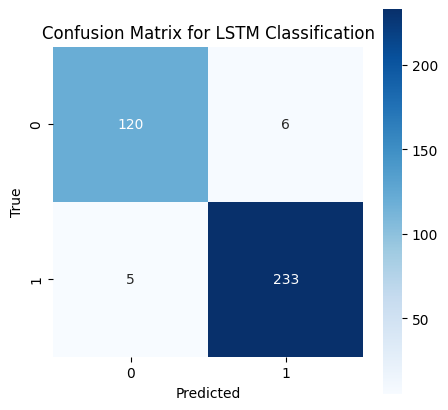

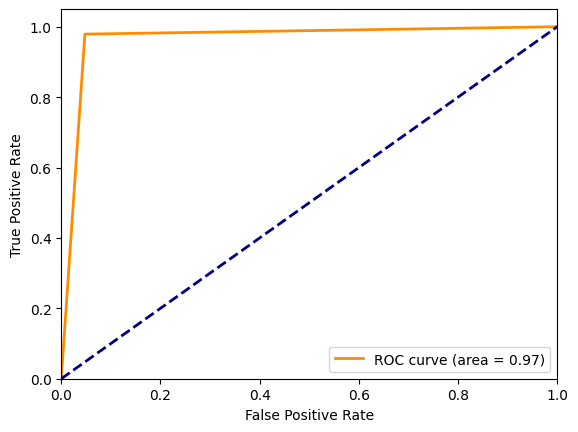

In [ ]:
# Classification Report
classification_rep1_lstmc = classification_report(y1_true1, y1_pred1)
print("Classification Report for LSTM Classification:\n")
print(classification_rep1_lstmc)

# Confusion Matrix
confusion1_lstmc = confusion_matrix(y1_true1, y1_pred1)
plt.figure(figsize=(5,5))
plt.imshow(confusion1_lstmc, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix for LSTM Classification')
sns.heatmap(confusion1_lstmc, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true1, y1_pred1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## 4.2 LSTM WITH RELU AND ADAM

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 39.3 MB/s eta 0:00:00


In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%tensorboard --logdir logs/fit/

Reusing TensorBoard on port 6006 (pid 4226), started 0:00:56 ago. (Use '!kill 4226' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
import keras_tuner as kt

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpointer = ModelCheckpoint(filepath="dnn/best_weights2.hdf5", verbose=0, save_best_only=True) # save best model

def model2(hp):
  model2 = tf.keras.Sequential()

  # Tune the number of LSTM layers and units per layer
  model2.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = True))
  for i in range(hp.Int('num_layers', min_value=1, max_value=6)):
    model2.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = True))
  # Last LSTM layer with return_sequences=False
  model2.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = False))

  # Tune the activation function
  hp_activation = hp.Choice('activation', values=['relu'])
  # Output layer with softmax activation
  model2.add(Dense(2, activation='softmax'))

  # Tune the learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the optimizer
  hp_optimizer = hp.Choice('optimizer', values=['adam'])
  if hp_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif hp_optimizer == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

  # Compile the model with the tuned learning rate and Adam/SGD optimizer
  model2.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  return model2

tuner2 = kt.BayesianOptimization(
    model2,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
)

tuner2.search(xseq_train, yseq_train, epochs=10, validation_data=(xseq_test, yseq_test),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

best_hps2 = tuner2.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal combination of hyperparameters
print("Optimal Hyperparameters:")
print(f"Number of Hidden Layers: {best_hps2.get('num_layers')}")
for i in range(best_hps2.get('num_layers')):
    units_key = 'units_' + str(i)
    if units_key in best_hps2:
        print(f"Layer {i + 1} - Units: {best_hps2.get(units_key)}")
print(f"Learning Rate: {best_hps2.get('learning_rate')}")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 5, verbose = 2, mode = 'auto')

# Build the final model with the best hyperparameters
final_model2 = tuner2.hypermodel.build(best_hps2)

# Train the final model with the best hyperparameters
final_model2.fit(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir, histogram_freq=1)],
                 verbose=2, epochs=1000)

final_model2.load_weights("dnn/best_weights2.hdf5")

final_model2.summary()

# Make predictions on the test data
y1_pred_prob2 = final_model2.predict(xseq_test)

# Convert predicted probabilities to binary labels
y1_pred2 = np.argmax(y1_pred_prob2, axis=1)

# Convert one-hot encoded test labels to binary labels
y1_true2 = np.argmax(yseq_test, axis=1)

Trial 10 Complete [00h 00m 37s]
val_accuracy: 0.8928571343421936

Best val_accuracy So Far: 0.942307710647583
Total elapsed time: 00h 04m 10s
Optimal Hyperparameters:
Number of Hidden Layers: 3
Learning Rate: 0.001
Epoch 1/1000
19/19 - 15s - loss: 0.6562 - accuracy: 0.6293 - val_loss: 0.5966 - val_accuracy: 0.6538 - 15s/epoch - 774ms/step
Epoch 2/1000
19/19 - 0s - loss: 0.6016 - accuracy: 0.6013 - val_loss: 0.6526 - val_accuracy: 0.6538 - 465ms/epoch - 24ms/step
Epoch 3/1000
19/19 - 1s - loss: 0.5585 - accuracy: 0.6409 - val_loss: 0.5431 - val_accuracy: 0.6484 - 609ms/epoch - 32ms/step
Epoch 4/1000
19/19 - 1s - loss: 0.5048 - accuracy: 0.7068 - val_loss: 0.4791 - val_accuracy: 0.7500 - 539ms/epoch - 28ms/step
Epoch 5/1000
19/19 - 1s - loss: 0.4354 - accuracy: 0.8089 - val_loss: 0.4253 - val_accuracy: 0.8214 - 560ms/epoch - 29ms/step
Epoch 6/1000
19/19 - 1s - loss: 0.3634 - accuracy: 0.8451 - val_loss: 0.3409 - val_accuracy: 0.8462 - 546ms/epoch - 29ms/step
Epoch 7/1000
19/19 - 0s - los

LSTM Classification with Relu and Adam:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       126
           1       0.98      0.98      0.98       238

    accuracy                           0.97       364
   macro avg       0.97      0.97      0.97       364
weighted avg       0.97      0.97      0.97       364



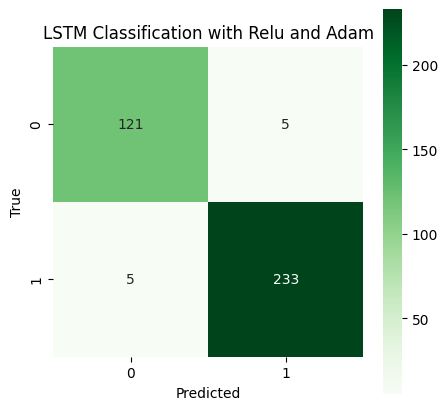

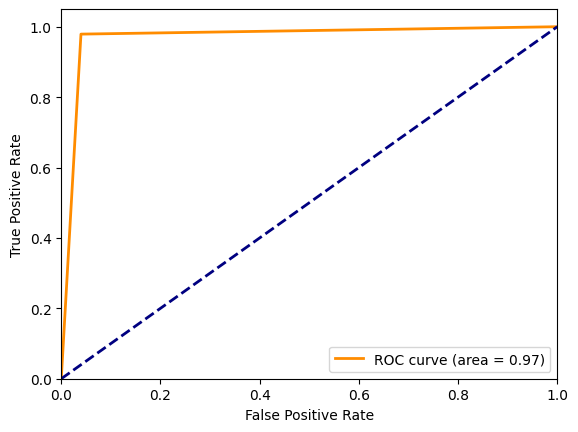

In [ ]:
# Classification Report
classification_report_lstm2 = classification_report(y1_true2, y1_pred2)
print("LSTM Classification with Relu and Adam:\n")
print(classification_report_lstm2)

# Confusion Matrix
confusion_matrix_lstm2 = confusion_matrix(y1_true2, y1_pred2)
plt.figure(figsize=(5,5))

# Display the Confusion Matrix as an image
plt.imshow(confusion_matrix_lstm2, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('LSTM Classification with Relu and Adam')

# Add annotations to the Confusion Matrix
sns.heatmap(confusion_matrix_lstm2, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true2, y1_pred2)
roc_auc = auc(fpr, tpr)

plt.figure()

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## 4.3 LSTM WITH TANH AND ADAM

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%tensorboard --logdir logs/fit/

Reusing TensorBoard on port 6006 (pid 4226), started 0:06:00 ago. (Use '!kill 4226' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpointer = ModelCheckpoint(filepath="dnn/best_weights3.hdf5", verbose=0, save_best_only=True) # save best model

def model3(hp):
  model3 = tf.keras.Sequential()

  # Tune the number of LSTM layers and units per layer
  model3.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = True))
  for i in range(hp.Int('num_layers', min_value=1, max_value=6)):
    model3.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = True))
  # Last LSTM layer with return_sequences=False
  model3.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = False))

  # Tune the activation function
  hp_activation = hp.Choice('activation', values=['tanh'])
  # Output layer with softmax activation
  model3.add(Dense(2, activation='softmax'))

  # Tune the learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the optimizer
  hp_optimizer = hp.Choice('optimizer', values=['adam'])
  if hp_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif hp_optimizer == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

  # Compile the model with the tuned learning rate and Adam/SGD optimizer
  model3.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  return model3

tuner3 = kt.BayesianOptimization(
    model3,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
)

tuner3.search(xseq_train, yseq_train, epochs=10, validation_data=(xseq_test, yseq_test),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

best_hps3 = tuner3.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal combination of hyperparameters
print("Optimal Hyperparameters:")
print(f"Number of Hidden Layers: {best_hps3.get('num_layers')}")
for i in range(best_hps3.get('num_layers')):
    units_key = 'units_' + str(i)
    if units_key in best_hps3:
        print(f"Layer {i + 1} - Units: {best_hps3.get(units_key)}")
print(f"Learning Rate: {best_hps3.get('learning_rate')}")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 5, verbose = 2, mode = 'auto')

# Build the final model with the best hyperparameters
final_model3 = tuner3.hypermodel.build(best_hps3)

# Train the final model with the best hyperparameters
final_model3.fit(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir, histogram_freq=1)],
                 verbose=2, epochs=1000)

final_model3.load_weights("dnn/best_weights3.hdf5")

final_model3.summary()

# Make predictions on the test data
y1_pred_prob3 = final_model3.predict(xseq_test)

# Convert predicted probabilities to binary labels
y1_pred3 = np.argmax(y1_pred_prob3, axis=1)

# Convert one-hot encoded test labels to binary labels
y1_true3 = np.argmax(yseq_test, axis=1)

Trial 10 Complete [00h 00m 35s]
val_accuracy: 0.848901093006134

Best val_accuracy So Far: 0.9642857313156128
Total elapsed time: 00h 04m 08s
Optimal Hyperparameters:
Number of Hidden Layers: 4
Learning Rate: 0.001
Epoch 1/1000
19/19 - 17s - loss: 0.6671 - accuracy: 0.6326 - val_loss: 0.6383 - val_accuracy: 0.6538 - 17s/epoch - 893ms/step
Epoch 2/1000
19/19 - 0s - loss: 0.6289 - accuracy: 0.6392 - val_loss: 0.5787 - val_accuracy: 0.6538 - 481ms/epoch - 25ms/step
Epoch 3/1000
19/19 - 0s - loss: 0.5430 - accuracy: 0.6392 - val_loss: 0.5428 - val_accuracy: 0.6511 - 495ms/epoch - 26ms/step
Epoch 4/1000
19/19 - 1s - loss: 0.4872 - accuracy: 0.7298 - val_loss: 0.4653 - val_accuracy: 0.7692 - 504ms/epoch - 27ms/step
Epoch 5/1000
19/19 - 1s - loss: 0.4275 - accuracy: 0.8105 - val_loss: 0.4232 - val_accuracy: 0.7967 - 585ms/epoch - 31ms/step
Epoch 6/1000
19/19 - 0s - loss: 0.3608 - accuracy: 0.8583 - val_loss: 0.3871 - val_accuracy: 0.8022 - 479ms/epoch - 25ms/step
Epoch 7/1000
19/19 - 0s - los

LSTM Classification with Tanh and Adam:

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       126
           1       0.97      0.96      0.97       238

    accuracy                           0.96       364
   macro avg       0.95      0.95      0.95       364
weighted avg       0.96      0.96      0.96       364



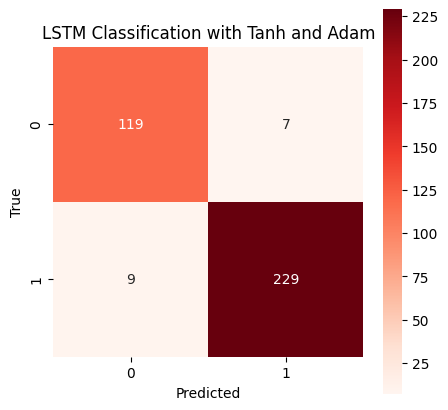

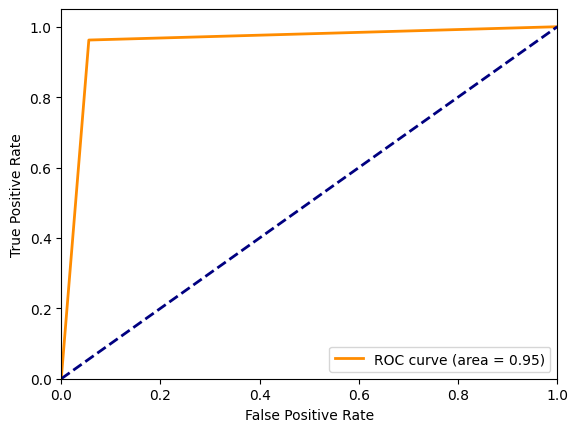

In [ ]:
# Classification Report
classification_report_lstm3 = classification_report(y1_true3, y1_pred3)
print("LSTM Classification with Tanh and Adam:\n")
print(classification_report_lstm3)

# Confusion Matrix
confusion_matrix_lstm3 = confusion_matrix(y1_true3, y1_pred3)
plt.figure(figsize=(5,5))

# Display the Confusion Matrix as an image
plt.imshow(confusion_matrix_lstm3, interpolation='nearest', cmap=plt.get_cmap('Reds'))
plt.title('LSTM Classification with Tanh and Adam')

# Add annotations to the Confusion Matrix
sns.heatmap(confusion_matrix_lstm3, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true3, y1_pred3)
roc_auc = auc(fpr, tpr)

plt.figure()

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## 4.4 LSTM WITH RELU AND SGD

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%tensorboard --logdir logs/fit/

Reusing TensorBoard on port 6006 (pid 4226), started 0:10:42 ago. (Use '!kill 4226' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
import keras_tuner as kt

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpointer = ModelCheckpoint(filepath="dnn/best_weights4.hdf5", verbose=0, save_best_only=True) # save best model

def model4(hp):
  model4 = tf.keras.Sequential()

  # Tune the number of LSTM layers and units per layer
  model4.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = True))
  for i in range(hp.Int('num_layers', min_value=1, max_value=6)):
    model4.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = True))
  # Last LSTM layer with return_sequences=False
  model4.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(xseq_train.shape[1], xseq_train.shape[2]), return_sequences = False))

  # Tune the activation function
  hp_activation = hp.Choice('activation', values=['relu'])
  # Output layer with softmax activation
  model4.add(Dense(2, activation='softmax'))

  # Tune the learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the optimizer
  hp_optimizer = hp.Choice('optimizer', values=['sgd'])
  if hp_optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)
  elif hp_optimizer == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate=hp_learning_rate)

  # Compile the model with the tuned learning rate and Adam/SGD optimizer
  model4.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  return model4

tuner4 = kt.BayesianOptimization(
    model4,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
)

tuner4.search(xseq_train, yseq_train, epochs=10, validation_data=(xseq_test, yseq_test),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

best_hps4 = tuner4.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal combination of hyperparameters
print("Optimal Hyperparameters:")
print(f"Number of Hidden Layers: {best_hps4.get('num_layers')}")
for i in range(best_hps4.get('num_layers')):
    units_key = 'units_' + str(i)
    if units_key in best_hps4:
        print(f"Layer {i + 1} - Units: {best_hps4.get(units_key)}")
print(f"Learning Rate: {best_hps4.get('learning_rate')}")

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience = 5, verbose = 2, mode = 'auto')

# Build the final model with the best hyperparameters
final_model4 = tuner4.hypermodel.build(best_hps3)

# Train the final model with the best hyperparameters
final_model4.fit(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir, histogram_freq=1)],
                 verbose=2, epochs=1000)

final_model4.load_weights("dnn/best_weights4.hdf5")

final_model4.summary()

# Make predictions on the test data
y1_pred_prob4 = final_model4.predict(xseq_test)

# Convert predicted probabilities to binary labels
y1_pred4 = np.argmax(y1_pred_prob4, axis=1)

# Convert one-hot encoded test labels to binary labels
y1_true4 = np.argmax(yseq_test, axis=1)

Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.6538461446762085

Best val_accuracy So Far: 0.6538461446762085
Total elapsed time: 00h 02m 35s
Optimal Hyperparameters:
Number of Hidden Layers: 2
Learning Rate: 0.001
Epoch 1/1000
19/19 - 20s - loss: 0.6669 - accuracy: 0.6161 - val_loss: 0.6397 - val_accuracy: 0.6538 - 20s/epoch - 1s/step
Epoch 2/1000
19/19 - 1s - loss: 0.6396 - accuracy: 0.6392 - val_loss: 0.5931 - val_accuracy: 0.6538 - 719ms/epoch - 38ms/step
Epoch 3/1000
19/19 - 1s - loss: 0.5488 - accuracy: 0.6557 - val_loss: 0.5287 - val_accuracy: 0.7115 - 575ms/epoch - 30ms/step
Epoch 4/1000
19/19 - 0s - loss: 0.4675 - accuracy: 0.7727 - val_loss: 0.4306 - val_accuracy: 0.7802 - 489ms/epoch - 26ms/step
Epoch 5/1000
19/19 - 0s - loss: 0.3909 - accuracy: 0.8386 - val_loss: 0.3466 - val_accuracy: 0.8352 - 476ms/epoch - 25ms/step
Epoch 6/1000
19/19 - 1s - loss: 0.3780 - accuracy: 0.8270 - val_loss: 0.4124 - val_accuracy: 0.7747 - 501ms/epoch - 26ms/step
Epoch 7/1000
19/19 - 1s - loss:

LSTM Classification with Relu and SGD:

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       126
           1       0.97      0.99      0.98       238

    accuracy                           0.97       364
   macro avg       0.98      0.96      0.97       364
weighted avg       0.97      0.97      0.97       364



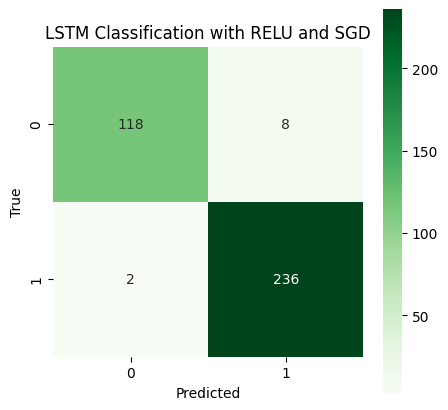

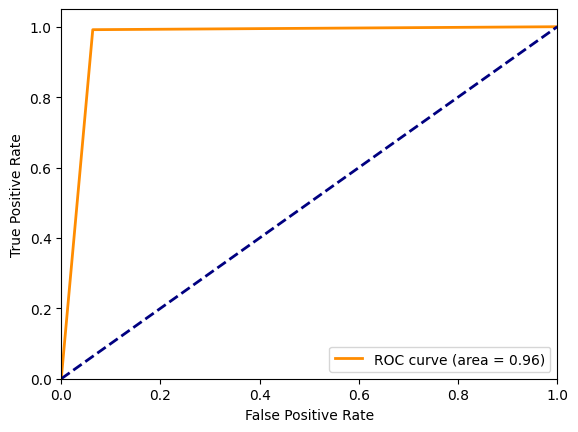

In [ ]:
# Classification Report
classification_report_lstm4 = classification_report(y1_true4, y1_pred4)
print("LSTM Classification with Relu and SGD:\n")
print(classification_report_lstm4)

# Confusion Matrix
confusion_matrix_lstm4 = confusion_matrix(y1_true4, y1_pred4)
plt.figure(figsize=(5,5))

# Display the Confusion Matrix as an image
plt.imshow(confusion_matrix_lstm4, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('LSTM Classification with RELU and SGD')

# Add annotations to the Confusion Matrix
sns.heatmap(confusion_matrix_lstm4, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true4, y1_pred4)
roc_auc = auc(fpr, tpr)

plt.figure()

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# 5.0 CNN Classification

## 5.1 CNN BASIC

In [ ]:
# Set up the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define sequence length and number of classes
sequence_length = 5
num_classes = 2

# Assuming you have already prepared your data using 'to_sequences' function
xseq_train, yseq_train = to_sequences(sequence_length, xl_train, y_shift_train)
xseq_test, yseq_test = to_sequences(sequence_length, xl_test, y_2_test)

# Check the shape of the data before reshaping
print("Original shapes: xseq_train", xseq_train.shape, "xseq_test", xseq_test.shape)

# Ensure the data is reshaped to match the model's expected input shape
xseq_train = xseq_train.reshape(xseq_train.shape[0], sequence_length, -1)
xseq_test = xseq_test.reshape(xseq_test.shape[0], sequence_length, -1)

# One-hot encode the target labels
yseq_train = tf.keras.utils.to_categorical(yseq_train, num_classes)

# Print the reshaped data shapes
print("Reshaped shapes: xseq_train", xseq_train.shape, "xseq_test", xseq_test.shape)

# Set up a ModelCheckpoint to save the best model
checkpointer = ModelCheckpoint(filepath="cnn/best_weights5.hdf5", verbose=0, save_best_only=True)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, xseq_train.shape[-1])))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Adding dropout for regularization
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Set up EarlyStopping for preventing overfitting
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

# Set up TensorBoard callback for monitoring training
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
model.fit(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test),
          callbacks=[monitor, checkpointer, tensorboard_callback],
          verbose=1, epochs=1000)

# Load the weights of the best model
model.load_weights("cnn/best_weights5.hdf5")

# Make predictions on the test data
pred = model.predict(xseq_test)

# Convert predictions and true labels to integers
y1_pred5 = np.argmax(pred, axis=1)
y1_true5 = np.argmax(yseq_test, axis=1)

# Print the first 5 predictions
for i in range(5):
    print('%s => %d (expected %d)' % (xseq_test[i].tolist(), y1_pred1[i], y1_true1[i]))


Original shapes: xseq_train (607, 5, 1, 1, 235) xseq_test (364, 5, 1, 1, 235)
Reshaped shapes: xseq_train (607, 5, 235) xseq_test (364, 5, 235)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             22592     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                          

Classification Report for CNN Classification:

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       126
           1       0.96      0.96      0.96       238

    accuracy                           0.95       364
   macro avg       0.94      0.94      0.94       364
weighted avg       0.95      0.95      0.95       364



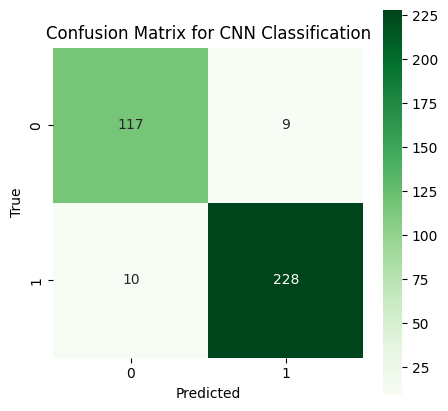

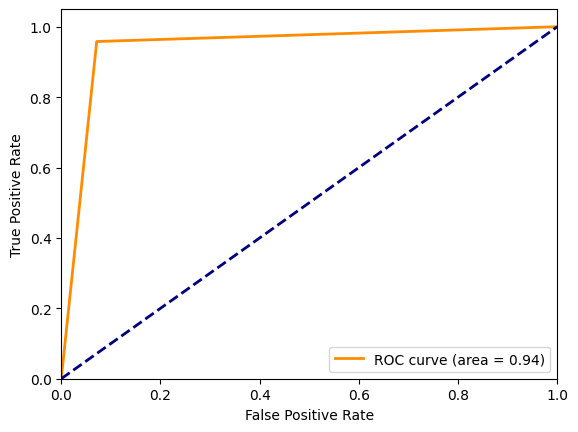

In [ ]:
# Classification Report
classification_rep = classification_report(y1_true5, y1_pred5)
print("Classification Report for CNN Classification:\n")
print(classification_rep)

# Confusion Matrix
confusion_matrix_cnn = confusion_matrix(y1_true5, y1_pred5)
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_cnn, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix for CNN Classification')
sns.heatmap(confusion_matrix_cnn, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true5, y1_pred5)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## 5.2 CNN WITH RELU AND ADAM

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%tensorboard --logdir logs/fit/

Reusing TensorBoard on port 6006 (pid 4226), started 0:14:23 ago. (Use '!kill 4226' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow import keras
import kerastuner as kt

# Set up the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up a ModelCheckpoint to save the best model
checkpointer = ModelCheckpoint(filepath="cnn/best_weights6.hdf5", verbose=0, save_best_only=True)

# Function to build the CNN model with hyperparameters
def build_model6(hp):
    model6 = Sequential()
    model6.add(Conv1D(filters=hp.Int('num_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation=hp.Choice('activation', values=['relu']),
                     input_shape=(sequence_length, xseq_train.shape[-1])))
    model6.add(MaxPooling1D(pool_size=1))
    model6.add(Flatten())
    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model6.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                       activation=hp.Choice(f'activation_{i}', values=['relu'])))
        model6.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    model6.add(Dense(num_classes, activation='softmax'))

    optimizer = hp.Choice('optimizer', values=['adam'])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model6.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model6

# Set up EarlyStopping for preventing overfitting
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

# Instantiate the Keras Tuner
tuner6 = kt.BayesianOptimization(
    build_model6,
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner_dir',
    project_name='cnn_tuner'
)

# Search for the best hyperparameters
tuner6.search(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), epochs=1000, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Get the best model
best_hps6 = tuner6.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal combination of hyperparameters
print("Optimal Hyperparameters:")
print(f"Number of Hidden Layers: {best_hps6.get('num_layers')}")
for i in range(best_hps6.get('num_layers')):
    units_key = 'units_' + str(i)
    if units_key in best_hps6:
        print(f"Layer {i + 1} - Units: {best_hps6.get(units_key)}")
print(f"Learning Rate: {best_hps6.get('learning_rate')}")

# Build the final model with the best hyperparameters
final_model6 = tuner6.hypermodel.build(best_hps6)

# Train the final model
final_model6.fit(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir)],
                verbose=1, epochs=1000)

# Load the weights of the best model
final_model6.load_weights("cnn/best_weights6.hdf5")

final_model6.summary()

# Make predictions on the test data
pred6 = final_model6.predict(xseq_test)

# Convert predictions and true labels to integers
y1_pred6 = np.argmax(pred6, axis=1)
y1_true6 = np.argmax(yseq_test, axis=1)


Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.9807692170143127

Best val_accuracy So Far: 0.9945054650306702
Total elapsed time: 00h 02m 06s
Optimal Hyperparameters:
Number of Hidden Layers: 4
Layer 1 - Units: 128
Layer 2 - Units: 512
Layer 3 - Units: 64
Layer 4 - Units: 512
Learning Rate: 0.0001
Epoch 1/1000
19/19 [==============================] - 5s 32ms/step - loss: 0.6543 - accuracy: 0.6359 - val_loss: 0.6331 - val_accuracy: 0.6538
Epoch 2/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.6373 - accuracy: 0.6442 - val_loss: 0.6138 - val_accuracy: 0.6538
Epoch 3/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.6120 - accuracy: 0.6359 - val_loss: 0.5941 - val_accuracy: 0.6538
Epoch 4/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.5743 - accuracy: 0.6524 - val_loss: 0.5654 - val_accuracy: 0.6648
Epoch 5/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.5498 - accuracy: 0.6507 - val_loss: 0.5367 - val_ac

CNN Classification with Relu and Adam:

              precision    recall  f1-score   support

           0       0.98      0.92      0.95       126
           1       0.96      0.99      0.98       238

    accuracy                           0.97       364
   macro avg       0.97      0.96      0.96       364
weighted avg       0.97      0.97      0.97       364



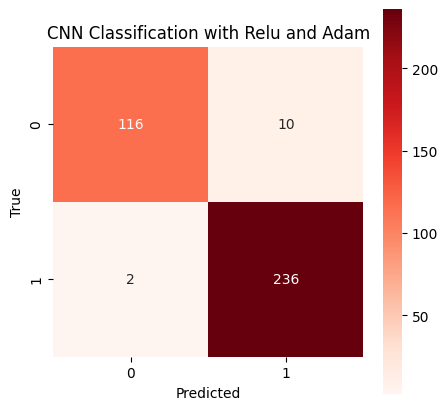

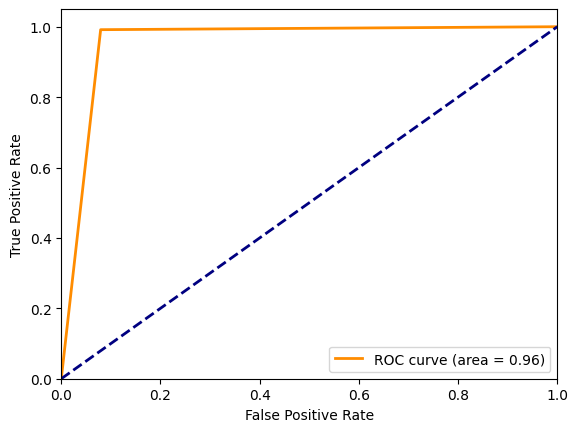

In [ ]:
# Classification Report
classification_rep6 = classification_report(y1_true6, y1_pred6)
print("CNN Classification with Relu and Adam:\n")
print(classification_rep6)

# Confusion Matrix
confusion_matrix_cnn6 = confusion_matrix(y1_true6, y1_pred6)
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_cnn6, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('CNN Classification with Relu and Adam')
sns.heatmap(confusion_matrix_cnn6, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true6, y1_pred6)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## 5.3 CNN WITH TANH AND ADAM

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%tensorboard --logdir logs/fit/

Reusing TensorBoard on port 6006 (pid 4226), started 0:16:48 ago. (Use '!kill 4226' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow import keras
import kerastuner as kt

# Set up the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up a ModelCheckpoint to save the best model
checkpointer = ModelCheckpoint(filepath="cnn/best_weights7.hdf5", verbose=0, save_best_only=True)

# Function to build the CNN model with hyperparameters
def build_model7(hp):
    model7 = Sequential()
    model7.add(Conv1D(filters=hp.Int('num_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation=hp.Choice('activation', values=['tanh']),
                     input_shape=(sequence_length, xseq_train.shape[-1])))
    model7.add(MaxPooling1D(pool_size=1))
    model7.add(Flatten())
    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model7.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                       activation=hp.Choice(f'activation_{i}', values=['tanh'])))
        model7.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    model7.add(Dense(num_classes, activation='softmax'))

    optimizer = hp.Choice('optimizer', values=['adam'])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model7.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model7

# Set up EarlyStopping for preventing overfitting
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

# Instantiate the Keras Tuner
tuner7 = kt.BayesianOptimization(
    build_model7,
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner_dir',
    project_name='cnn_tuner'
)

# Search for the best hyperparameters
tuner7.search(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), epochs=1000, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Get the best model
best_hps7 = tuner7.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal combination of hyperparameters
print("Optimal Hyperparameters:")
print(f"Number of Hidden Layers: {best_hps7.get('num_layers')}")
for i in range(best_hps7.get('num_layers')):
    units_key = 'units_' + str(i)
    if units_key in best_hps7:
        print(f"Layer {i + 1} - Units: {best_hps7.get(units_key)}")
print(f"Learning Rate: {best_hps7.get('learning_rate')}")

# Build the final model with the best hyperparameters
final_model7 = tuner7.hypermodel.build(best_hps7)

# Train the final model
final_model7.fit(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir)],
                verbose=1, epochs=1000)

# Load the weights of the best model
final_model7.load_weights("cnn/best_weights7.hdf5")

final_model7.summary()

# Make predictions on the test data
pred7 = final_model7.predict(xseq_test)

# Convert predictions and true labels to integers
y1_pred7 = np.argmax(pred7, axis=1)
y1_true7 = np.argmax(yseq_test, axis=1)


Reloading Tuner from keras_tuner_dir/cnn_tuner/tuner0.json
Optimal Hyperparameters:
Number of Hidden Layers: 4
Layer 1 - Units: 128
Layer 2 - Units: 512
Layer 3 - Units: 64
Layer 4 - Units: 512
Learning Rate: 0.0001
Epoch 1/1000
19/19 [==============================] - 4s 32ms/step - loss: 0.6532 - accuracy: 0.6293 - val_loss: 0.6327 - val_accuracy: 0.6538
Epoch 2/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.6423 - accuracy: 0.6359 - val_loss: 0.6163 - val_accuracy: 0.6538
Epoch 3/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.6217 - accuracy: 0.6343 - val_loss: 0.5954 - val_accuracy: 0.6538
Epoch 4/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.5896 - accuracy: 0.6392 - val_loss: 0.5771 - val_accuracy: 0.6538
Epoch 5/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.5574 - accuracy: 0.6326 - val_loss: 0.5484 - val_accuracy: 0.7555
Epoch 6/1000
19/19 [==============================] - 0s 17ms/step - 

CNN Classification with Tanh and Adam:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       126
           1       0.98      0.97      0.98       238

    accuracy                           0.97       364
   macro avg       0.97      0.97      0.97       364
weighted avg       0.97      0.97      0.97       364



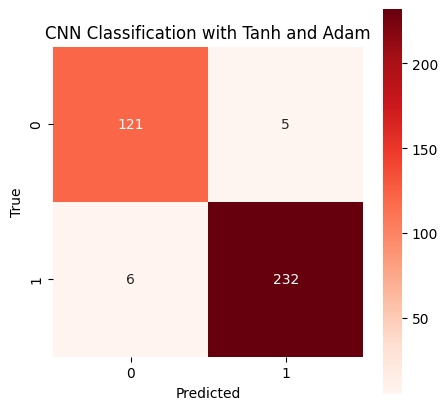

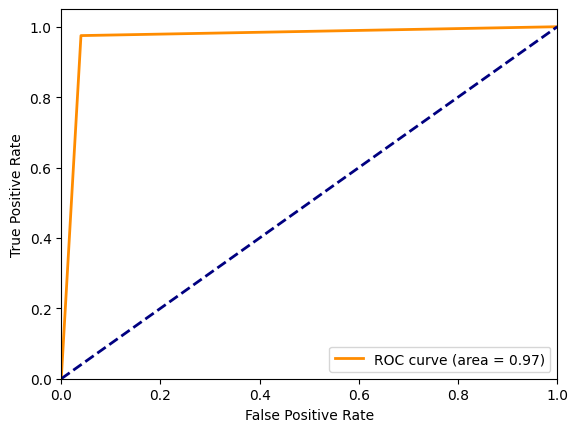

In [ ]:
# Classification Report
classification_rep7 = classification_report(y1_true7, y1_pred7)
print("CNN Classification with Tanh and Adam:\n")
print(classification_rep7)

# Confusion Matrix
confusion_matrix_cnn7 = confusion_matrix(y1_true7, y1_pred7)
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_cnn7, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('CNN Classification with Tanh and Adam')
sns.heatmap(confusion_matrix_cnn7, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true7, y1_pred7)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


## 5.4 CNN WITH RELU AND SGD

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [ ]:
%tensorboard --logdir logs/fit/

Reusing TensorBoard on port 6006 (pid 4226), started 0:17:11 ago. (Use '!kill 4226' to kill it.)

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow import keras
import kerastuner as kt

# Set up the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Set up a ModelCheckpoint to save the best model
checkpointer = ModelCheckpoint(filepath="cnn/best_weights8.hdf5", verbose=0, save_best_only=True)

# Function to build the CNN model with hyperparameters
def build_model8(hp):
    model8 = Sequential()
    model8.add(Conv1D(filters=hp.Int('num_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation=hp.Choice('activation', values=['relu']),
                     input_shape=(sequence_length, xseq_train.shape[-1])))
    model8.add(MaxPooling1D(pool_size=1))
    model8.add(Flatten())
    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model8.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                       activation=hp.Choice(f'activation_{i}', values=['relu'])))
        model8.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    model8.add(Dense(num_classes, activation='softmax'))

    optimizer = hp.Choice('optimizer', values=['sgd'])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

    model8.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model8

# Set up EarlyStopping for preventing overfitting
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

# Instantiate the Keras Tuner
tuner8 = kt.BayesianOptimization(
    build_model8,
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner_dir',
    project_name='cnn_tuner'
)

# Search for the best hyperparameters
tuner8.search(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), epochs=1000, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

# Get the best model
best_hps8 = tuner8.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal combination of hyperparameters
print("Optimal Hyperparameters:")
print(f"Number of Hidden Layers: {best_hps8.get('num_layers')}")
for i in range(best_hps8.get('num_layers')):
    units_key = 'units_' + str(i)
    if units_key in best_hps8:
        print(f"Layer {i + 1} - Units: {best_hps8.get(units_key)}")
print(f"Learning Rate: {best_hps8.get('learning_rate')}")

# Build the final model with the best hyperparameters
final_model8 = tuner8.hypermodel.build(best_hps8)

# Train the final model
final_model8.fit(xseq_train, yseq_train, validation_data=(xseq_test, yseq_test), callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir)],
                verbose=1, epochs=1000)

# Load the weights of the best model
final_model8.load_weights("cnn/best_weights7.hdf5")

final_model8.summary()

# Make predictions on the test data
pred8 = final_model8.predict(xseq_test)

# Convert predictions and true labels to integers
y1_pred8 = np.argmax(pred8, axis=1)
y1_true8 = np.argmax(yseq_test, axis=1)


Reloading Tuner from keras_tuner_dir/cnn_tuner/tuner0.json
Optimal Hyperparameters:
Number of Hidden Layers: 4
Layer 1 - Units: 128
Layer 2 - Units: 512
Layer 3 - Units: 64
Layer 4 - Units: 512
Learning Rate: 0.0001
Epoch 1/1000
19/19 [==============================] - 4s 31ms/step - loss: 0.6609 - accuracy: 0.6293 - val_loss: 0.6438 - val_accuracy: 0.6538
Epoch 2/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.6396 - accuracy: 0.6392 - val_loss: 0.6307 - val_accuracy: 0.6538
Epoch 3/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.6303 - accuracy: 0.6392 - val_loss: 0.6177 - val_accuracy: 0.6538
Epoch 4/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.6075 - accuracy: 0.6392 - val_loss: 0.5831 - val_accuracy: 0.6538
Epoch 5/1000
19/19 [==============================] - 0s 11ms/step - loss: 0.5605 - accuracy: 0.6425 - val_loss: 0.5421 - val_accuracy: 0.6648
Epoch 6/1000
19/19 [==============================] - 0s 10ms/step - 

CNN Classification with Relu and SGD:

              precision    recall  f1-score   support

           0       0.95      0.96      0.96       126
           1       0.98      0.97      0.98       238

    accuracy                           0.97       364
   macro avg       0.97      0.97      0.97       364
weighted avg       0.97      0.97      0.97       364



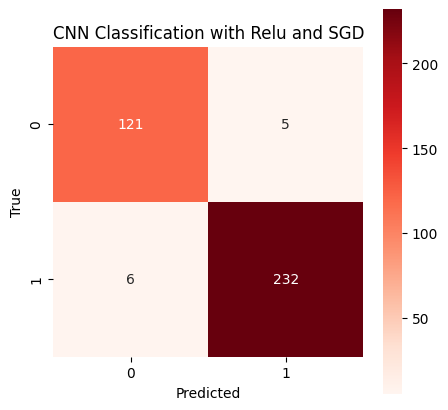

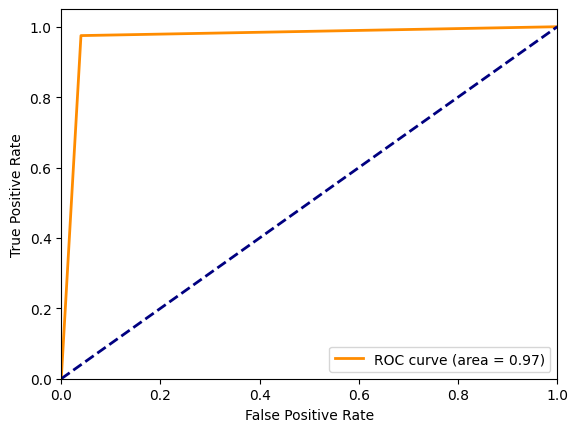

In [ ]:
# Classification Report
classification_rep8 = classification_report(y1_true8, y1_pred8)
print("CNN Classification with Relu and SGD:\n")
print(classification_rep8)

# Confusion Matrix
confusion_matrix_cnn8 = confusion_matrix(y1_true8, y1_pred8)
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_cnn8, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('CNN Classification with Relu and SGD')
sns.heatmap(confusion_matrix_cnn8, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true8, y1_pred8)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# 6.0 ADDITIONAL FEATURES- BEST SEQUENCE SIZE

## 6.1 FINDING EFFICIENT N FOR LSTM

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
num_classes = 2

best_sequence_length = 0
best_accuracy = 0

for sequence_length in range(4, 28):
    xseq_train1, yseq_train1 = to_sequences(sequence_length, xl_train, y_shift_train)
    xseq_train1 = np.reshape(xseq_train1, (xseq_train1.shape[0], sequence_length, xseq_train1.shape[-1]))

    xseq_test1, yseq_test1 = to_sequences(sequence_length, xl_test, y_2_test)
    xseq_test1 = np.reshape(xseq_test1, (xseq_test1.shape[0], sequence_length, xseq_test1.shape[-1]))

    yseq_train1 = tf.keras.utils.to_categorical(yseq_train1, num_classes)

    checkpointer = ModelCheckpoint(filepath=f"dnn/best_weights9_{sequence_length}.hdf5", verbose=0, save_best_only=True)

    print(f'Build model with sequence_length={sequence_length}...')
    model9 = Sequential()
    model9.add(LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2, input_shape=(sequence_length, xseq_train.shape[2])))
    model9.add(Dense(2, activation='softmax'))

    model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    print(f'Training model with sequence_length={sequence_length}...')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model9.fit(xseq_train1, yseq_train1, validation_data=(xseq_test1, yseq_test1),
               callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir, histogram_freq=1)],
               verbose=1, epochs=1000)

    model9.load_weights(f"dnn/best_weights9_{sequence_length}.hdf5")

    _, accuracy = model9.evaluate(xseq_test1, yseq_test1, verbose=0)
    print(f"Accuracy for sequence_length={sequence_length}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sequence_length = sequence_length

print(f"The most efficient sequence_length is: {best_sequence_length}")


Build model with sequence_length=4...
Training model with sequence_length=4...
Epoch 1/1000
19/19 [==============================] - 3s 51ms/step - loss: 0.6611 - accuracy: 0.6069 - val_loss: 0.5746 - val_accuracy: 0.6384
Epoch 2/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.5393 - accuracy: 0.6497 - val_loss: 0.5429 - val_accuracy: 0.6877
Epoch 3/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.4823 - accuracy: 0.7072 - val_loss: 0.5015 - val_accuracy: 0.7370
Epoch 4/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.4683 - accuracy: 0.7648 - val_loss: 0.6952 - val_accuracy: 0.5808
Epoch 5/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4326 - accuracy: 0.7977 - val_loss: 0.4162 - val_accuracy: 0.8110
Epoch 6/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.3792 - accuracy: 0.8273 - val_loss: 0.4569 - val_accuracy: 0.7753
Epoch 7/1000
19/19 [==============================] - 1s 28ms/s

Accuracy for sequence_length=4: 0.9424657821655273
Build model with sequence_length=5...
Training model with sequence_length=5...
Epoch 1/1000
19/19 [==============================] - 4s 52ms/step - loss: 0.6283 - accuracy: 0.6244 - val_loss: 0.5601 - val_accuracy: 0.6703
Epoch 2/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.5236 - accuracy: 0.6969 - val_loss: 0.5243 - val_accuracy: 0.7280
Epoch 3/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4544 - accuracy: 0.7710 - val_loss: 0.5190 - val_accuracy: 0.7198
Epoch 4/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4036 - accuracy: 0.8204 - val_loss: 0.3879 - val_accuracy: 0.8077
Epoch 5/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.3564 - accuracy: 0.8386 - val_loss: 0.6600 - val_accuracy: 0.7115
Epoch 6/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.3193 - accuracy: 0.8583 - val_loss: 0.2865 - val_accuracy: 0.8791
Epoch 7/1000

Accuracy for sequence_length=5: 0.958791196346283
Build model with sequence_length=6...
Training model with sequence_length=6...
Epoch 1/1000
19/19 [==============================] - 5s 100ms/step - loss: 0.7135 - accuracy: 0.6040 - val_loss: 0.5481 - val_accuracy: 0.5950
Epoch 2/1000
19/19 [==============================] - 2s 81ms/step - loss: 0.5262 - accuracy: 0.6469 - val_loss: 0.6214 - val_accuracy: 0.5895
Epoch 3/1000
19/19 [==============================] - 1s 74ms/step - loss: 0.5147 - accuracy: 0.6947 - val_loss: 0.5457 - val_accuracy: 0.6887
Epoch 4/1000
19/19 [==============================] - 1s 71ms/step - loss: 0.4842 - accuracy: 0.7327 - val_loss: 0.4964 - val_accuracy: 0.7686
Epoch 5/1000
19/19 [==============================] - 1s 73ms/step - loss: 0.4379 - accuracy: 0.7954 - val_loss: 0.4331 - val_accuracy: 0.7245
Epoch 6/1000
19/19 [==============================] - 1s 72ms/step - loss: 0.3759 - accuracy: 0.8383 - val_loss: 0.4338 - val_accuracy: 0.7906
Epoch 7/1000

Accuracy for sequence_length=6: 0.9752066135406494
Build model with sequence_length=7...
Training model with sequence_length=7...
Epoch 1/1000
19/19 [==============================] - 6s 108ms/step - loss: 0.6999 - accuracy: 0.6083 - val_loss: 0.5946 - val_accuracy: 0.6740
Epoch 2/1000
19/19 [==============================] - 2s 83ms/step - loss: 0.5196 - accuracy: 0.6727 - val_loss: 0.5165 - val_accuracy: 0.7541
Epoch 3/1000
19/19 [==============================] - 1s 40ms/step - loss: 0.4490 - accuracy: 0.7983 - val_loss: 0.4602 - val_accuracy: 0.7873
Epoch 4/1000
19/19 [==============================] - 1s 38ms/step - loss: 0.4145 - accuracy: 0.7934 - val_loss: 0.4685 - val_accuracy: 0.7652
Epoch 5/1000
19/19 [==============================] - 1s 39ms/step - loss: 0.3610 - accuracy: 0.8562 - val_loss: 0.3858 - val_accuracy: 0.7928
Epoch 6/1000
19/19 [==============================] - 1s 37ms/step - loss: 0.4199 - accuracy: 0.7736 - val_loss: 0.4792 - val_accuracy: 0.7431
Epoch 7/100

Accuracy for sequence_length=7: 0.8453038930892944
Build model with sequence_length=8...
Training model with sequence_length=8...
Epoch 1/1000
19/19 [==============================] - 8s 194ms/step - loss: 0.7335 - accuracy: 0.5795 - val_loss: 0.5964 - val_accuracy: 0.6593
Epoch 2/1000
19/19 [==============================] - 2s 93ms/step - loss: 0.5647 - accuracy: 0.6275 - val_loss: 0.5480 - val_accuracy: 0.7036
Epoch 3/1000
19/19 [==============================] - 1s 48ms/step - loss: 0.4953 - accuracy: 0.7368 - val_loss: 0.5805 - val_accuracy: 0.6233
Epoch 4/1000
19/19 [==============================] - 1s 44ms/step - loss: 0.4296 - accuracy: 0.7881 - val_loss: 0.4813 - val_accuracy: 0.7729
Epoch 5/1000
19/19 [==============================] - 1s 41ms/step - loss: 0.3772 - accuracy: 0.8245 - val_loss: 0.4827 - val_accuracy: 0.7729
Epoch 6/1000
19/19 [==============================] - 1s 48ms/step - loss: 0.3350 - accuracy: 0.8460 - val_loss: 0.3083 - val_accuracy: 0.8560
Epoch 7/100

Accuracy for sequence_length=8: 0.9778393507003784
Build model with sequence_length=9...
Training model with sequence_length=9...
Epoch 1/1000
19/19 [==============================] - 4s 68ms/step - loss: 0.6496 - accuracy: 0.5937 - val_loss: 0.5867 - val_accuracy: 0.6472
Epoch 2/1000
19/19 [==============================] - 2s 90ms/step - loss: 0.5334 - accuracy: 0.7081 - val_loss: 0.5453 - val_accuracy: 0.6833
Epoch 3/1000
19/19 [==============================] - 2s 95ms/step - loss: 0.4543 - accuracy: 0.7861 - val_loss: 0.4714 - val_accuracy: 0.7750
Epoch 4/1000
19/19 [==============================] - 2s 98ms/step - loss: 0.3512 - accuracy: 0.8524 - val_loss: 0.3664 - val_accuracy: 0.8194
Epoch 5/1000
19/19 [==============================] - 2s 90ms/step - loss: 0.3013 - accuracy: 0.8773 - val_loss: 0.3680 - val_accuracy: 0.8000
Epoch 6/1000
19/19 [==============================] - 2s 100ms/step - loss: 0.2519 - accuracy: 0.8939 - val_loss: 0.3691 - val_accuracy: 0.8083
Epoch 7/100

Accuracy for sequence_length=9: 0.9666666388511658
Build model with sequence_length=10...
Training model with sequence_length=10...
Epoch 1/1000
19/19 [==============================] - 6s 127ms/step - loss: 0.7551 - accuracy: 0.5748 - val_loss: 0.5422 - val_accuracy: 0.6630
Epoch 2/1000
19/19 [==============================] - 2s 105ms/step - loss: 0.5307 - accuracy: 0.6993 - val_loss: 0.5458 - val_accuracy: 0.6602
Epoch 3/1000
19/19 [==============================] - 1s 62ms/step - loss: 0.4691 - accuracy: 0.7558 - val_loss: 0.4912 - val_accuracy: 0.7521
Epoch 4/1000
19/19 [==============================] - 1s 47ms/step - loss: 0.4257 - accuracy: 0.8040 - val_loss: 0.4368 - val_accuracy: 0.7883
Epoch 5/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.3408 - accuracy: 0.8654 - val_loss: 0.5356 - val_accuracy: 0.7298
Epoch 6/1000
19/19 [==============================] - 1s 50ms/step - loss: 0.2951 - accuracy: 0.8688 - val_loss: 0.2724 - val_accuracy: 0.8468
Epoch 7/

Accuracy for sequence_length=10: 0.941504180431366
Build model with sequence_length=11...
Training model with sequence_length=11...
Epoch 1/1000
19/19 [==============================] - 5s 71ms/step - loss: 0.6436 - accuracy: 0.6240 - val_loss: 0.5751 - val_accuracy: 0.6369
Epoch 2/1000
19/19 [==============================] - 1s 57ms/step - loss: 0.5264 - accuracy: 0.7155 - val_loss: 0.7229 - val_accuracy: 0.5335
Epoch 3/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.4882 - accuracy: 0.7338 - val_loss: 0.4535 - val_accuracy: 0.7542
Epoch 4/1000
19/19 [==============================] - 1s 58ms/step - loss: 0.4132 - accuracy: 0.8087 - val_loss: 0.4056 - val_accuracy: 0.8324
Epoch 5/1000
19/19 [==============================] - 1s 53ms/step - loss: 0.3110 - accuracy: 0.8802 - val_loss: 0.4219 - val_accuracy: 0.7849
Epoch 6/1000
19/19 [==============================] - 1s 52ms/step - loss: 0.2973 - accuracy: 0.8686 - val_loss: 0.2851 - val_accuracy: 0.8575
Epoch 7/10

Accuracy for sequence_length=11: 0.9748603105545044
Build model with sequence_length=12...
Training model with sequence_length=12...
Epoch 1/1000
19/19 [==============================] - 4s 75ms/step - loss: 0.6493 - accuracy: 0.6183 - val_loss: 0.5689 - val_accuracy: 0.6246
Epoch 2/1000
19/19 [==============================] - 1s 63ms/step - loss: 0.5383 - accuracy: 0.7083 - val_loss: 0.5640 - val_accuracy: 0.6723
Epoch 3/1000
19/19 [==============================] - 1s 59ms/step - loss: 0.4591 - accuracy: 0.7767 - val_loss: 0.5697 - val_accuracy: 0.6835
Epoch 4/1000
19/19 [==============================] - 1s 61ms/step - loss: 0.3651 - accuracy: 0.8567 - val_loss: 0.3602 - val_accuracy: 0.7983
Epoch 5/1000
19/19 [==============================] - 1s 57ms/step - loss: 0.3006 - accuracy: 0.8800 - val_loss: 0.3484 - val_accuracy: 0.8067
Epoch 6/1000
19/19 [==============================] - 1s 76ms/step - loss: 0.2680 - accuracy: 0.8833 - val_loss: 0.4873 - val_accuracy: 0.7759
Epoch 7/1

Accuracy for sequence_length=12: 0.9831932783126831
Build model with sequence_length=13...
Training model with sequence_length=13...
Epoch 1/1000
19/19 [==============================] - 4s 81ms/step - loss: 0.7064 - accuracy: 0.6060 - val_loss: 0.5977 - val_accuracy: 0.5815
Epoch 2/1000
19/19 [==============================] - 1s 65ms/step - loss: 0.5450 - accuracy: 0.6728 - val_loss: 0.5566 - val_accuracy: 0.6685
Epoch 3/1000
19/19 [==============================] - 2s 118ms/step - loss: 0.4785 - accuracy: 0.7780 - val_loss: 0.6210 - val_accuracy: 0.6180
Epoch 4/1000
19/19 [==============================] - 2s 131ms/step - loss: 0.4006 - accuracy: 0.8297 - val_loss: 0.5646 - val_accuracy: 0.7331
Epoch 5/1000
19/19 [==============================] - 2s 127ms/step - loss: 0.4249 - accuracy: 0.8314 - val_loss: 0.5329 - val_accuracy: 0.6882
Epoch 6/1000
19/19 [==============================] - 2s 131ms/step - loss: 0.3580 - accuracy: 0.8765 - val_loss: 0.4516 - val_accuracy: 0.7781
Epoch

Accuracy for sequence_length=13: 0.966292142868042
Build model with sequence_length=14...
Training model with sequence_length=14...
Epoch 1/1000
19/19 [==============================] - 7s 157ms/step - loss: 0.8197 - accuracy: 0.5819 - val_loss: 0.6325 - val_accuracy: 0.5803
Epoch 2/1000
19/19 [==============================] - 2s 132ms/step - loss: 0.5455 - accuracy: 0.6756 - val_loss: 0.5023 - val_accuracy: 0.6873
Epoch 3/1000
19/19 [==============================] - 1s 74ms/step - loss: 0.4576 - accuracy: 0.7826 - val_loss: 0.4758 - val_accuracy: 0.7972
Epoch 4/1000
19/19 [==============================] - 1s 67ms/step - loss: 0.4878 - accuracy: 0.7575 - val_loss: 0.5665 - val_accuracy: 0.6282
Epoch 5/1000
19/19 [==============================] - 1s 71ms/step - loss: 0.4458 - accuracy: 0.7625 - val_loss: 0.5222 - val_accuracy: 0.7014
Epoch 6/1000
19/19 [==============================] - 1s 71ms/step - loss: 0.3995 - accuracy: 0.8127 - val_loss: 0.3855 - val_accuracy: 0.8000
Epoch 7/

Accuracy for sequence_length=14: 0.9464788436889648
Build model with sequence_length=15...
Training model with sequence_length=15...
Epoch 1/1000
19/19 [==============================] - 7s 190ms/step - loss: 0.6769 - accuracy: 0.5980 - val_loss: 0.5594 - val_accuracy: 0.6610
Epoch 2/1000
19/19 [==============================] - 3s 148ms/step - loss: 0.5281 - accuracy: 0.6901 - val_loss: 0.5925 - val_accuracy: 0.6271
Epoch 3/1000
19/19 [==============================] - 3s 153ms/step - loss: 0.4911 - accuracy: 0.7471 - val_loss: 0.4898 - val_accuracy: 0.7684
Epoch 4/1000
19/19 [==============================] - 3s 139ms/step - loss: 0.4069 - accuracy: 0.8224 - val_loss: 0.5422 - val_accuracy: 0.7514
Epoch 5/1000
19/19 [==============================] - 3s 145ms/step - loss: 0.3644 - accuracy: 0.8442 - val_loss: 0.6007 - val_accuracy: 0.6695
Epoch 6/1000
19/19 [==============================] - 3s 147ms/step - loss: 0.3429 - accuracy: 0.8409 - val_loss: 0.4182 - val_accuracy: 0.7994
Epo

Accuracy for sequence_length=15: 0.9830508232116699
Build model with sequence_length=16...
Training model with sequence_length=16...
Epoch 1/1000
19/19 [==============================] - 9s 197ms/step - loss: 0.6912 - accuracy: 0.6292 - val_loss: 0.6455 - val_accuracy: 0.5524
Epoch 2/1000
19/19 [==============================] - 2s 133ms/step - loss: 0.5225 - accuracy: 0.7215 - val_loss: 0.4958 - val_accuracy: 0.8074
Epoch 3/1000
19/19 [==============================] - 1s 80ms/step - loss: 0.4247 - accuracy: 0.7987 - val_loss: 0.4728 - val_accuracy: 0.7620
Epoch 4/1000
19/19 [==============================] - 1s 75ms/step - loss: 0.3893 - accuracy: 0.8255 - val_loss: 0.5089 - val_accuracy: 0.7054
Epoch 5/1000
19/19 [==============================] - 2s 83ms/step - loss: 0.3304 - accuracy: 0.8473 - val_loss: 0.4346 - val_accuracy: 0.7564
Epoch 6/1000
19/19 [==============================] - 1s 80ms/step - loss: 0.3487 - accuracy: 0.8272 - val_loss: 0.5589 - val_accuracy: 0.6912
Epoch 7

Training model with sequence_length=17...
Epoch 1/1000
19/19 [==============================] - 7s 204ms/step - loss: 0.6528 - accuracy: 0.6235 - val_loss: 0.6429 - val_accuracy: 0.5824
Epoch 2/1000
19/19 [==============================] - 3s 174ms/step - loss: 0.5226 - accuracy: 0.6992 - val_loss: 0.5790 - val_accuracy: 0.6335
Epoch 3/1000
19/19 [==============================] - 2s 111ms/step - loss: 0.5103 - accuracy: 0.7311 - val_loss: 0.4642 - val_accuracy: 0.7443
Epoch 4/1000
19/19 [==============================] - 2s 83ms/step - loss: 0.4758 - accuracy: 0.7361 - val_loss: 0.4535 - val_accuracy: 0.8352
Epoch 5/1000
19/19 [==============================] - 1s 76ms/step - loss: 0.3817 - accuracy: 0.8387 - val_loss: 0.3248 - val_accuracy: 0.8438
Epoch 6/1000
19/19 [==============================] - 1s 79ms/step - loss: 0.3423 - accuracy: 0.8571 - val_loss: 0.3261 - val_accuracy: 0.8295
Epoch 7/1000
19/19 [==============================] - 2s 80ms/step - loss: 0.3254 - accuracy: 0.8

Accuracy for sequence_length=17: 0.9801136255264282
Build model with sequence_length=18...
Training model with sequence_length=18...
Epoch 1/1000
19/19 [==============================] - 8s 216ms/step - loss: 0.8739 - accuracy: 0.5791 - val_loss: 0.6128 - val_accuracy: 0.6268
Epoch 2/1000
19/19 [==============================] - 3s 152ms/step - loss: 0.5123 - accuracy: 0.7071 - val_loss: 0.6464 - val_accuracy: 0.7493
Epoch 3/1000
19/19 [==============================] - 2s 82ms/step - loss: 0.4609 - accuracy: 0.7963 - val_loss: 0.5520 - val_accuracy: 0.6923
Epoch 4/1000
19/19 [==============================] - 2s 83ms/step - loss: 0.3820 - accuracy: 0.8300 - val_loss: 0.6162 - val_accuracy: 0.7009
Epoch 5/1000
19/19 [==============================] - 2s 85ms/step - loss: 0.3524 - accuracy: 0.8401 - val_loss: 0.4836 - val_accuracy: 0.7521
Epoch 6/1000
19/19 [==============================] - 2s 82ms/step - loss: 0.3302 - accuracy: 0.8636 - val_loss: 0.3698 - val_accuracy: 0.8205
Epoch 7

Accuracy for sequence_length=18: 0.9857549667358398
Build model with sequence_length=19...
Training model with sequence_length=19...
Epoch 1/1000
19/19 [==============================] - 5s 106ms/step - loss: 0.7058 - accuracy: 0.5818 - val_loss: 0.5884 - val_accuracy: 0.6600
Epoch 2/1000
19/19 [==============================] - 2s 89ms/step - loss: 0.5604 - accuracy: 0.6560 - val_loss: 0.6323 - val_accuracy: 0.5971
Epoch 3/1000
19/19 [==============================] - 2s 80ms/step - loss: 0.5347 - accuracy: 0.6931 - val_loss: 0.6006 - val_accuracy: 0.7314
Epoch 4/1000
19/19 [==============================] - 3s 160ms/step - loss: 0.4820 - accuracy: 0.7521 - val_loss: 0.4232 - val_accuracy: 0.8286
Epoch 5/1000
19/19 [==============================] - 3s 174ms/step - loss: 0.3799 - accuracy: 0.8229 - val_loss: 0.6121 - val_accuracy: 0.7229
Epoch 6/1000
19/19 [==============================] - 4s 186ms/step - loss: 0.3334 - accuracy: 0.8550 - val_loss: 0.3105 - val_accuracy: 0.8629
Epoch

Accuracy for sequence_length=19: 0.9857142567634583
Build model with sequence_length=20...
Training model with sequence_length=20...
Epoch 1/1000
19/19 [==============================] - 5s 105ms/step - loss: 0.7011 - accuracy: 0.6132 - val_loss: 0.7597 - val_accuracy: 0.4900
Epoch 2/1000
19/19 [==============================] - 2s 91ms/step - loss: 0.5554 - accuracy: 0.6571 - val_loss: 0.6281 - val_accuracy: 0.5731
Epoch 3/1000
19/19 [==============================] - 2s 100ms/step - loss: 0.4957 - accuracy: 0.7331 - val_loss: 0.7073 - val_accuracy: 0.5387
Epoch 4/1000
19/19 [==============================] - 2s 95ms/step - loss: 0.4724 - accuracy: 0.7416 - val_loss: 0.5043 - val_accuracy: 0.7163
Epoch 5/1000
19/19 [==============================] - 3s 180ms/step - loss: 0.4179 - accuracy: 0.8108 - val_loss: 0.4104 - val_accuracy: 0.7937
Epoch 6/1000
19/19 [==============================] - 3s 180ms/step - loss: 0.3626 - accuracy: 0.8277 - val_loss: 0.4901 - val_accuracy: 0.7593
Epoch

Accuracy for sequence_length=20: 0.982807993888855
Build model with sequence_length=21...
Training model with sequence_length=21...
Epoch 1/1000
19/19 [==============================] - 7s 210ms/step - loss: 0.7099 - accuracy: 0.6024 - val_loss: 0.5628 - val_accuracy: 0.6839
Epoch 2/1000
19/19 [==============================] - 4s 204ms/step - loss: 0.5606 - accuracy: 0.6481 - val_loss: 0.5114 - val_accuracy: 0.6839
Epoch 3/1000
19/19 [==============================] - 3s 161ms/step - loss: 0.5201 - accuracy: 0.6937 - val_loss: 0.4550 - val_accuracy: 0.7443
Epoch 4/1000
19/19 [==============================] - 2s 89ms/step - loss: 0.4522 - accuracy: 0.7530 - val_loss: 0.5028 - val_accuracy: 0.7989
Epoch 5/1000
19/19 [==============================] - 2s 89ms/step - loss: 0.3862 - accuracy: 0.8376 - val_loss: 0.3617 - val_accuracy: 0.8218
Epoch 6/1000
19/19 [==============================] - 2s 92ms/step - loss: 0.4587 - accuracy: 0.7631 - val_loss: 0.4375 - val_accuracy: 0.8075
Epoch 7

Accuracy for sequence_length=21: 0.9683908224105835
Build model with sequence_length=22...
Training model with sequence_length=22...
Epoch 1/1000
19/19 [==============================] - 8s 183ms/step - loss: 0.7858 - accuracy: 0.5983 - val_loss: 0.5947 - val_accuracy: 0.5476
Epoch 2/1000
19/19 [==============================] - 2s 97ms/step - loss: 0.5485 - accuracy: 0.6644 - val_loss: 0.5623 - val_accuracy: 0.6801
Epoch 3/1000
19/19 [==============================] - 2s 92ms/step - loss: 0.5306 - accuracy: 0.7000 - val_loss: 0.4854 - val_accuracy: 0.6916
Epoch 4/1000
19/19 [==============================] - 2s 98ms/step - loss: 0.4831 - accuracy: 0.7508 - val_loss: 0.4755 - val_accuracy: 0.7867
Epoch 5/1000
19/19 [==============================] - 2s 95ms/step - loss: 0.4094 - accuracy: 0.8220 - val_loss: 0.3486 - val_accuracy: 0.8501
Epoch 6/1000
19/19 [==============================] - 2s 96ms/step - loss: 0.4004 - accuracy: 0.8271 - val_loss: 0.4333 - val_accuracy: 0.8300
Epoch 7/

Accuracy for sequence_length=22: 0.9769452214241028
Build model with sequence_length=23...
Training model with sequence_length=23...
Epoch 1/1000
19/19 [==============================] - 5s 116ms/step - loss: 0.7424 - accuracy: 0.5671 - val_loss: 0.5625 - val_accuracy: 0.6879
Epoch 2/1000
19/19 [==============================] - 2s 99ms/step - loss: 0.5663 - accuracy: 0.6570 - val_loss: 0.5723 - val_accuracy: 0.6503
Epoch 3/1000
19/19 [==============================] - 2s 99ms/step - loss: 0.5275 - accuracy: 0.7402 - val_loss: 0.4223 - val_accuracy: 0.8179
Epoch 4/1000
19/19 [==============================] - 3s 149ms/step - loss: 0.4614 - accuracy: 0.7759 - val_loss: 0.4638 - val_accuracy: 0.7977
Epoch 5/1000
19/19 [==============================] - 4s 200ms/step - loss: 0.3942 - accuracy: 0.8065 - val_loss: 0.4741 - val_accuracy: 0.7312
Epoch 6/1000
19/19 [==============================] - 4s 218ms/step - loss: 0.3959 - accuracy: 0.7912 - val_loss: 0.3909 - val_accuracy: 0.8208
Epoch

Build model with sequence_length=24...
Training model with sequence_length=24...
Epoch 1/1000
19/19 [==============================] - 8s 246ms/step - loss: 0.6176 - accuracy: 0.6190 - val_loss: 0.5457 - val_accuracy: 0.7014
Epoch 2/1000
19/19 [==============================] - 3s 181ms/step - loss: 0.5067 - accuracy: 0.7432 - val_loss: 0.4662 - val_accuracy: 0.8174
Epoch 3/1000
19/19 [==============================] - 2s 103ms/step - loss: 0.3782 - accuracy: 0.8299 - val_loss: 0.4302 - val_accuracy: 0.7797
Epoch 4/1000
19/19 [==============================] - 2s 106ms/step - loss: 0.3572 - accuracy: 0.8452 - val_loss: 0.5964 - val_accuracy: 0.6580
Epoch 5/1000
19/19 [==============================] - 2s 103ms/step - loss: 0.3564 - accuracy: 0.8231 - val_loss: 0.9061 - val_accuracy: 0.7739
Epoch 6/1000
19/19 [==============================] - 2s 102ms/step - loss: 0.3295 - accuracy: 0.8827 - val_loss: 0.3827 - val_accuracy: 0.8145
Epoch 7/1000
19/19 [==============================] - 2

Accuracy for sequence_length=24: 0.95652174949646
Build model with sequence_length=25...
Training model with sequence_length=25...
Epoch 1/1000
19/19 [==============================] - 6s 124ms/step - loss: 0.7417 - accuracy: 0.6014 - val_loss: 0.6154 - val_accuracy: 0.6453
Epoch 2/1000
19/19 [==============================] - 2s 105ms/step - loss: 0.5396 - accuracy: 0.6695 - val_loss: 0.5890 - val_accuracy: 0.6424
Epoch 3/1000
19/19 [==============================] - 2s 105ms/step - loss: 0.4467 - accuracy: 0.7973 - val_loss: 0.3808 - val_accuracy: 0.8517
Epoch 4/1000
19/19 [==============================] - 2s 108ms/step - loss: 0.3908 - accuracy: 0.8194 - val_loss: 0.3893 - val_accuracy: 0.8110
Epoch 5/1000
19/19 [==============================] - 4s 234ms/step - loss: 0.3057 - accuracy: 0.8739 - val_loss: 0.2838 - val_accuracy: 0.8576
Epoch 6/1000
19/19 [==============================] - 4s 227ms/step - loss: 0.2667 - accuracy: 0.9012 - val_loss: 0.3370 - val_accuracy: 0.8314
Epoch

Accuracy for sequence_length=25: 0.9622092843055725
Build model with sequence_length=26...
Training model with sequence_length=26...
Epoch 1/1000
19/19 [==============================] - 5s 149ms/step - loss: 0.7461 - accuracy: 0.6348 - val_loss: 0.5689 - val_accuracy: 0.6910
Epoch 2/1000
19/19 [==============================] - 4s 226ms/step - loss: 0.5662 - accuracy: 0.6706 - val_loss: 0.6050 - val_accuracy: 0.6531
Epoch 3/1000
19/19 [==============================] - 5s 247ms/step - loss: 0.5017 - accuracy: 0.7218 - val_loss: 0.9418 - val_accuracy: 0.5364
Epoch 4/1000
19/19 [==============================] - 3s 132ms/step - loss: 0.5429 - accuracy: 0.7116 - val_loss: 0.4945 - val_accuracy: 0.7609
Epoch 5/1000
19/19 [==============================] - 2s 104ms/step - loss: 0.4443 - accuracy: 0.8140 - val_loss: 0.4627 - val_accuracy: 0.7726
Epoch 6/1000
19/19 [==============================] - 2s 106ms/step - loss: 0.3940 - accuracy: 0.8020 - val_loss: 0.4529 - val_accuracy: 0.7755
Epo

Accuracy for sequence_length=26: 0.9708454608917236
Build model with sequence_length=27...
Training model with sequence_length=27...
Epoch 1/1000
19/19 [==============================] - 8s 222ms/step - loss: 1.0458 - accuracy: 0.5846 - val_loss: 0.5709 - val_accuracy: 0.6608
Epoch 2/1000
19/19 [==============================] - 2s 110ms/step - loss: 0.5716 - accuracy: 0.6479 - val_loss: 0.5408 - val_accuracy: 0.6462
Epoch 3/1000
19/19 [==============================] - 2s 111ms/step - loss: 0.5450 - accuracy: 0.6752 - val_loss: 0.5180 - val_accuracy: 0.7339
Epoch 4/1000
19/19 [==============================] - 2s 116ms/step - loss: 0.5078 - accuracy: 0.7214 - val_loss: 0.5330 - val_accuracy: 0.7222
Epoch 5/1000
19/19 [==============================] - 2s 114ms/step - loss: 0.4239 - accuracy: 0.8034 - val_loss: 0.3126 - val_accuracy: 0.8596
Epoch 6/1000
19/19 [==============================] - 3s 182ms/step - loss: 0.3848 - accuracy: 0.8137 - val_loss: 0.3182 - val_accuracy: 0.8772
Epo

In [ ]:
from tensorflow.keras.optimizers import Adam, SGD

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
num_classes = 2

best_sequence_length = 0
best_accuracy = 0

# Define a list of sequence lengths to test
sequence_lengths_to_test = [19]  # Set the desired sequence length

for sequence_length in sequence_lengths_to_test:
    xseq_train2, yseq_train2 = to_sequences(sequence_length, xl_train, y_shift_train)
    xseq_train2 = np.reshape(xseq_train2, (xseq_train2.shape[0], sequence_length, xseq_train2.shape[-1]))

    xseq_test2, yseq_test2 = to_sequences(sequence_length, xl_test, y_2_test)
    xseq_test2 = np.reshape(xseq_test2, (xseq_test2.shape[0], sequence_length, xseq_test2.shape[-1]))

    yseq_train2 = tf.keras.utils.to_categorical(yseq_train2, num_classes)

    checkpointer = ModelCheckpoint(filepath=f"dnn/best_weights2_{sequence_length}.hdf5", verbose=0, save_best_only=True)

    print(f'Build model with sequence_length={sequence_length}...')
    def model10(hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), input_shape=(sequence_length, xseq_train2.shape[-1]), return_sequences=True))
        for i in range(hp.Int('num_layers', min_value=1, max_value=6)):
            model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), return_sequences=True))
        model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=256, step=32), return_sequences=False))
        hp_activation = hp.Choice('activation', values=['relu'])
        model.add(Dense(num_classes, activation='softmax'))

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        hp_optimizer = hp.Choice('optimizer', values=['adam'])
        if hp_optimizer == 'adam':
            optimizer = Adam(learning_rate=hp_learning_rate)
        elif hp_optimizer == 'sgd':
            optimizer = SGD(learning_rate=hp_learning_rate)

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    tuner10 = kt.BayesianOptimization(
        model10,
        objective="val_accuracy",
        max_trials=10,
        directory='keras_tuner_dir',
        project_name='dnn_tuner'
    )

    tuner10.search(xseq_train2, yseq_train2, epochs=10, validation_data=(xseq_test2, yseq_test2),
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)])

    best_hps10 = tuner10.get_best_hyperparameters(num_trials=1)[0]

    # Print the optimal combination of hyperparameters
    print("Optimal Hyperparameters:")
    print(f"Number of Hidden Layers: {best_hps10.get('num_layers')}")
    for i in range(best_hps10.get('num_layers')):
        units_key = 'lstm_units_' + str(i)
        if units_key in best_hps10:
            print(f"Layer {i + 1} - Units: {best_hps10.get(units_key)}")
    print(f"Learning Rate: {best_hps10.get('learning_rate')}")

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    # Build the final model with the best hyperparameters
    final_model10 = tuner10.hypermodel.build(best_hps10)

    # Train the final model with the best hyperparameters
    final_model10.fit(xseq_train2, yseq_train2, validation_data=(xseq_test2, yseq_test2), callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir, histogram_freq=1)],
                     verbose=2, epochs=1000)

    final_model10.load_weights(f"dnn/best_weights2_{sequence_length}.hdf5")

    final_model10.summary()

    # Make predictions on the test data
    y1_pred_prob10 = final_model10.predict(xseq_test2)

    # Convert predicted probabilities to binary labels
    y1_pred10 = np.argmax(y1_pred_prob10, axis=1)

    # Convert one-hot encoded test labels to binary labels
    y1_true10 = np.argmax(yseq_test2, axis=1)


Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.6800000071525574

Best val_accuracy So Far: 0.9571428298950195
Total elapsed time: 00h 04m 01s
Optimal Hyperparameters:
Number of Hidden Layers: 1
Learning Rate: 0.001
Epoch 1/1000
19/19 - 10s - loss: 0.6857 - accuracy: 0.5987 - val_loss: 0.6094 - val_accuracy: 0.6800 - 10s/epoch - 540ms/step
Epoch 2/1000
19/19 - 1s - loss: 0.6014 - accuracy: 0.6425 - val_loss: 0.6184 - val_accuracy: 0.6543 - 625ms/epoch - 33ms/step
Epoch 3/1000
19/19 - 1s - loss: 0.5802 - accuracy: 0.6358 - val_loss: 0.5522 - val_accuracy: 0.6600 - 763ms/epoch - 40ms/step
Epoch 4/1000
19/19 - 1s - loss: 0.5344 - accuracy: 0.6863 - val_loss: 0.5181 - val_accuracy: 0.7086 - 665ms/epoch - 35ms/step
Epoch 5/1000
19/19 - 1s - loss: 0.5022 - accuracy: 0.7234 - val_loss: 0.5025 - val_accuracy: 0.7600 - 632ms/epoch - 33ms/step
Epoch 6/1000
19/19 - 1s - loss: 0.4075 - accuracy: 0.8094 - val_loss: 0.4656 - val_accuracy: 0.7629 - 713ms/epoch - 38ms/step
Epoch 7/1000
19/19 - 1s - lo

LSTM Classification with Relu and Adam (19):

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       112
           1       0.98      1.00      0.99       238

    accuracy                           0.99       350
   macro avg       0.99      0.98      0.98       350
weighted avg       0.99      0.99      0.99       350



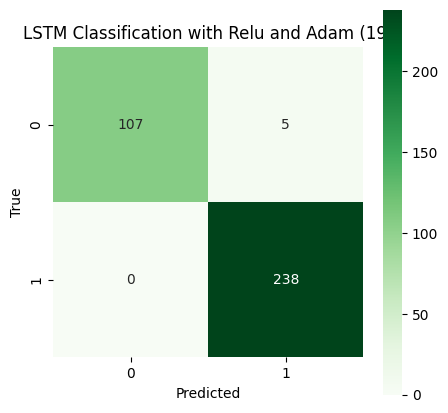

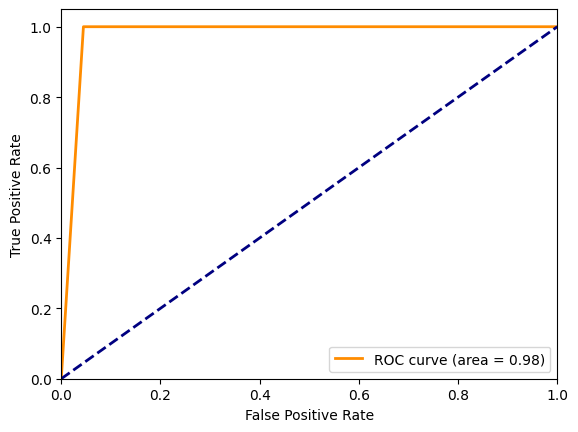

In [ ]:
# Classification Report
classification_report_lstm10 = classification_report(y1_true10, y1_pred10)
print("LSTM Classification with Relu and Adam (19):\n")
print(classification_report_lstm10)

# Confusion Matrix
confusion_matrix_lstm10 = confusion_matrix(y1_true10, y1_pred10)
plt.figure(figsize=(5,5))

# Display the Confusion Matrix as an image
plt.imshow(confusion_matrix_lstm10, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('LSTM Classification with Relu and Adam (19)')

# Add annotations to the Confusion Matrix
sns.heatmap(confusion_matrix_lstm10, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true10, y1_pred10)
roc_auc = auc(fpr, tpr)

plt.figure()

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

## 6.2 FINDING EFFICIENT N FOR CNN

In [ ]:
# Set up the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

best_sequence_length = 0
best_accuracy = 0

# Define the number of classes
num_classes = 2


# Iterate over different sequence lengths
for sequence_length in range(4, 28):
    # Assuming you have already prepared your data using the 'to_sequences' function
    xseq_train3, yseq_train3 = to_sequences(sequence_length, xl_train, y_shift_train)
    xseq_test3, yseq_test3 = to_sequences(sequence_length, xl_test, y_2_test)

    # Ensure the data is reshaped to match the model's expected input shape
    xseq_train3 = xseq_train3.reshape(xseq_train3.shape[0], sequence_length, xseq_train3.shape[-1])
    xseq_test3 = xseq_test3.reshape(xseq_test3.shape[0], sequence_length, xseq_test3.shape[-1])

    # One-hot encode the target labels
    yseq_train3 = tf.keras.utils.to_categorical(yseq_train3, num_classes)

    # Set up a ModelCheckpoint to save the best model
    checkpointer = ModelCheckpoint(filepath=f"cnn/best_weights11_{sequence_length}.hdf5", verbose=0, save_best_only=True)

    # Build the CNN model
    model11 = Sequential()
    model11.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, xseq_train3.shape[-1])))
    model11.add(MaxPooling1D(pool_size=2))
    model11.add(Flatten())
    model11.add(Dense(128, activation='relu'))
    model11.add(Dropout(0.2))  # Adding dropout for regularization
    model11.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model11.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print model summary
    model11.summary()

    # Set up EarlyStopping for preventing overfitting
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

    # Set up TensorBoard callback for monitoring training
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Train the model
    model11.fit(xseq_train3, yseq_train3, validation_data=(xseq_test3, yseq_test3),
              callbacks=[monitor, checkpointer, tensorboard_callback],
              verbose=1, epochs=1000)

    # Load the weights of the best model
    model11.load_weights(f"cnn/best_weights11_{sequence_length}.hdf5")

    # Evaluate the model
    _, accuracy = model11.evaluate(xseq_test3, yseq_test3, verbose=0)
    print(f"Accuracy for sequence_length={sequence_length}: {accuracy}")

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_sequence_length = sequence_length

print(f"The most efficient sequence_length is: {best_sequence_length}")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             22592     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               4224      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                      

In [ ]:
from tensorflow.keras.utils import to_categorical

# Set up the log directory for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define sequence length and number of classes
sequence_length = 5
num_classes = 2

# Assuming you have already prepared your data using 'to_sequences' function
xseq_train4, yseq_train4 = to_sequences(sequence_length, xl_train, y_shift_train)
xseq_test4, yseq_test4 = to_sequences(sequence_length, xl_test, y_2_test)

# Check the shape of the data before reshaping
print("Original shapes: xseq_train4", xseq_train4.shape, "xseq_test", xseq_test4.shape)

# Ensure the data is reshaped to match the model's expected input shape
xseq_train4 = xseq_train4.reshape(xseq_train4.shape[0], sequence_length, -1)
xseq_test4 = xseq_test4.reshape(xseq_test4.shape[0], sequence_length, -1)

# One-hot encode the target labels
yseq_train4 = tf.keras.utils.to_categorical(yseq_train4, num_classes)

# Print the reshaped data shapes
print("Reshaped shapes: xseq_train4", xseq_train4.shape, "xseq_test4", xseq_test4.shape)

checkpointer = ModelCheckpoint(filepath=f"dnn/best_weights12_{sequence_length}.hdf5", verbose=0, save_best_only=True)

# Function to build the CNN model with hyperparameters
def build_model12(hp):
    model12 = Sequential()
    model12.add(Conv1D(filters=hp.Int('num_filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3]),  # Changed to kernel size 3
                     activation=hp.Choice('activation', values=['relu']),
                     input_shape=(sequence_length, xseq_train4.shape[-1])))
    model12.add(MaxPooling1D(pool_size=1))
    model12.add(Flatten())
    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model12.add(Dense(units=hp.Int(f'units_{i}', min_value=64, max_value=512, step=64),
                       activation=hp.Choice(f'activation_{i}', values=['relu'])))
        model12.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    model12.add(Dense(num_classes, activation='softmax'))

    optimizer = hp.Choice('optimizer', values=['adam'])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    model12.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model12

# Set up EarlyStopping for preventing overfitting
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

# Instantiate the Keras Tuner
tuner12 = kt.BayesianOptimization(
    build_model12,
    objective='val_accuracy',
    max_trials=10,
    directory='keras_tuner_dir',
    project_name='cnn_tuner'
)

# Search for the best hyperparameters
tuner12.search(xseq_train4, yseq_train4, validation_data=(xseq_test4, yseq_test4), epochs=1000, verbose=1, callbacks=[monitor])

# Get the best model
best_hps12 = tuner12.get_best_hyperparameters(num_trials=1)[0]

# Print the optimal combination of hyperparameters
print("Optimal Hyperparameters:")
print(f"Number of Hidden Layers: {best_hps12.get('num_layers')}")
for i in range(best_hps12.get('num_layers')):
    units_key = 'units_' + str(i)
    if units_key in best_hps12:
        print(f"Layer {i + 1} - Units: {best_hps12.get(units_key)}")
print(f"Learning Rate: {best_hps12.get('learning_rate')}")

# Build the final model with the best hyperparameters
final_model12 = tuner12.hypermodel.build(best_hps12)

# Train the final model
final_model12.fit(xseq_train4, yseq_train4, validation_data=(xseq_test4, yseq_test4), callbacks=[monitor, checkpointer, TensorBoard(log_dir=log_dir)],
                verbose=1, epochs=1000)

# Load the weights of the best model
final_model12.load_weights(f"dnn/best_weights12_{sequence_length}.hdf5")

final_model12.summary()

# Make predictions on the test data
pred12 = final_model12.predict(xseq_test4)

# Convert predictions and true labels to integers
y1_pred12 = np.argmax(pred12, axis=1)
y1_true12 = np.argmax(yseq_test4, axis=1)


Original shapes: xseq_train4 (607, 5, 1, 1, 235) xseq_test (364, 5, 1, 1, 235)
Reshaped shapes: xseq_train4 (607, 5, 235) xseq_test4 (364, 5, 235)
Reloading Tuner from keras_tuner_dir/cnn_tuner/tuner0.json
Optimal Hyperparameters:
Number of Hidden Layers: 4
Layer 1 - Units: 128
Layer 2 - Units: 512
Layer 3 - Units: 64
Layer 4 - Units: 512
Learning Rate: 0.0001
Epoch 1/1000
19/19 [==============================] - 4s 34ms/step - loss: 0.6483 - accuracy: 0.6392 - val_loss: 0.6347 - val_accuracy: 0.6538
Epoch 2/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.6272 - accuracy: 0.6359 - val_loss: 0.6069 - val_accuracy: 0.6538
Epoch 3/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.6079 - accuracy: 0.6376 - val_loss: 0.5795 - val_accuracy: 0.6676
Epoch 4/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.5758 - accuracy: 0.6623 - val_loss: 0.5582 - val_accuracy: 0.6209
Epoch 5/1000
19/19 [==============================] - 0s 16ms/ste

CNN Classification with Relu and Adam (4):

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       126
           1       0.98      0.97      0.97       238

    accuracy                           0.97       364
   macro avg       0.96      0.97      0.96       364
weighted avg       0.97      0.97      0.97       364



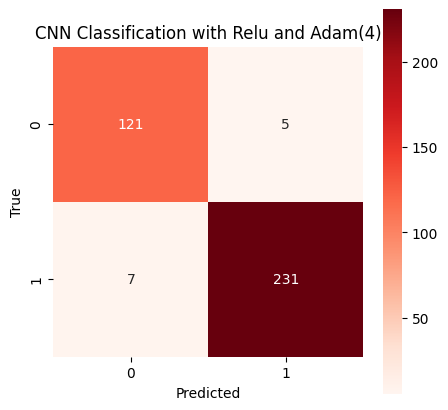

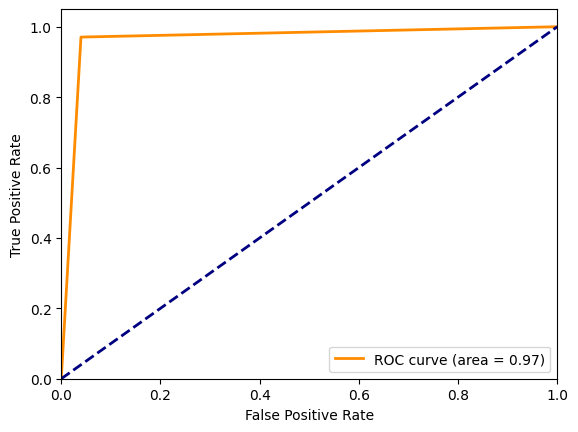

In [ ]:
# Classification Report
classification_rep12 = classification_report(y1_true12, y1_pred12)
print("CNN Classification with Relu and Adam (4):\n")
print(classification_rep12)

# Confusion Matrix
confusion_matrix_cnn12 = confusion_matrix(y1_true12, y1_pred12)
plt.figure(figsize=(5,5))
plt.imshow(confusion_matrix_cnn12, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('CNN Classification with Relu and Adam(4)')
sns.heatmap(confusion_matrix_cnn12, annot=True, fmt="d", cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true12, y1_pred12)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


# 7.0 ADDITIONAL FEATURES- TRANSFORMER

In [ ]:
import numpy as np
import datetime
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, Embedding, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

sequence_length = 19
num_classes = 2

print(xseq_train2.shape)
print(xseq_test2.shape)
print(yseq_train2.shape)
print(yseq_test2.shape)

checkpointer = ModelCheckpoint(filepath="transformer/best_weights13.hdf5", verbose=0, save_best_only=True)

print('Build model...')
input_layer = Input(shape=(sequence_length, xseq_train2.shape[-1]))
# Use the same input for both query and value
attention_output = MultiHeadAttention(num_heads=8, key_dim=128)(query=input_layer, value=input_layer)

# Apply Global Average Pooling to the attention output
pooling_output = GlobalAveragePooling1D()(attention_output)
output_layer = Dense(num_classes, activation='softmax')(pooling_output)

model13 = Model(inputs=input_layer, outputs=output_layer)

model13.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Train...')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model13.fit(xseq_train2, yseq_train2, validation_data=(xseq_test2, yseq_test2),
          callbacks=[monitor, checkpointer, tensorboard_callback],
          verbose=1, epochs=1000)

model13.load_weights("transformer/best_weights13.hdf5")

pred13 = model13.predict(xseq_test2)

y1_pred13 = np.argmax(pred13, axis=1)
y1_true13 = np.argmax(yseq_test2, axis=1)

for i in range(5):
    print('%s => %d (expected %d)' % (xseq_test[i].tolist(), y1_pred1[i], y1_true1[i]))


(593, 19, 235)
(350, 19, 235)
(593, 2)
(350, 2)
Build model...
Train...
Epoch 1/1000
19/19 [==============================] - 4s 52ms/step - loss: 1.1976 - accuracy: 0.5767 - val_loss: 0.7496 - val_accuracy: 0.4400
Epoch 2/1000
19/19 [==============================] - 1s 37ms/step - loss: 0.6922 - accuracy: 0.5750 - val_loss: 0.7278 - val_accuracy: 0.4743
Epoch 3/1000
19/19 [==============================] - 1s 36ms/step - loss: 0.6458 - accuracy: 0.6020 - val_loss: 0.5850 - val_accuracy: 0.6743
Epoch 4/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5625 - accuracy: 0.6830 - val_loss: 0.5093 - val_accuracy: 0.7543
Epoch 5/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.5198 - accuracy: 0.7234 - val_loss: 0.4766 - val_accuracy: 0.7200
Epoch 6/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.4810 - accuracy: 0.7454 - val_loss: 0.4494 - val_accuracy: 0.7714
Epoch 7/1000
19/19 [==============================] - 0s 26ms/step - l

LSTM with Multiheaded Attention:

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       112
           1       0.93      0.95      0.94       238

    accuracy                           0.92       350
   macro avg       0.91      0.90      0.91       350
weighted avg       0.92      0.92      0.92       350



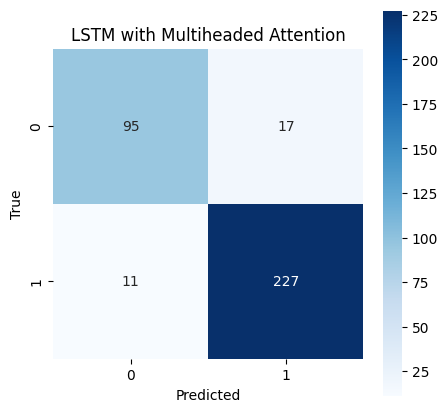

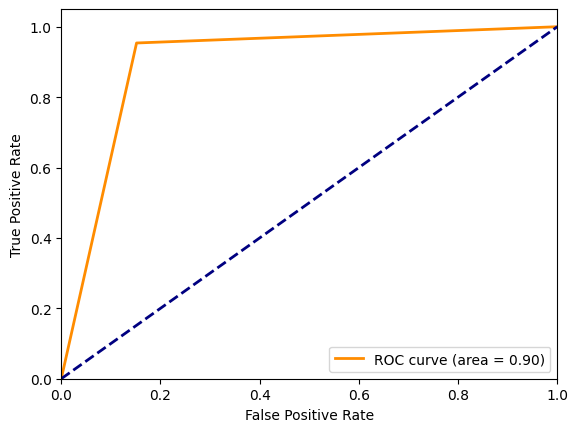

In [ ]:
# Classification Report
classification_report_lstm13 = classification_report(y1_true13, y1_pred13)
print("LSTM with Multiheaded Attention:\n")
print(classification_report_lstm13)

# Confusion Matrix
confusion_matrix_lstm13 = confusion_matrix(y1_true13, y1_pred13)
plt.figure(figsize=(5,5))

# Display the Confusion Matrix as an image
plt.imshow(confusion_matrix_lstm13, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('LSTM with Multiheaded Attention')

# Add annotations to the Confusion Matrix
sns.heatmap(confusion_matrix_lstm13, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y1_true13, y1_pred13)
roc_auc = auc(fpr, tpr)

plt.figure()

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()